In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

import env
import acquire_zillow
import prepare


# Zillow Project
### Project Goals
- What features drive the housing prices 
- Create a model that beats the current baseline



### Project Description
- Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

- Find the key drivers of property value for single family properties. Some questions that come to mind are: Why do some properties have a much higher value than others when they are located so close to each other? Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? Is having 1 bathroom worse than having 2 bedrooms?

# Data Acquisition 

- #### Acuired the Zillow data from the Sql database 
- #### Saved the data in a csv file
- #### Stored the data in a in a function as a dataframe 
- #### The original data has 52440 rows and 6 columns

    - 'bathroomcnt'
    - 'bedroomcnt'
    - 'calculatedfinishedsquarefeet'
    - 'taxvaluedollarcnt'
    - 'fibs'
    - 'yearbuilt'
- #### The cleaned data has 48372 rows and 6 columns 

# Preparation

### Steps taken for a clean dataset
1. #### Adressed missing values by dropping them since they were less than 10% of the initial data 

2. #### In order to simulate an ordinary homebuyer I took care of the outliers by:
     - removing houses over 6000 sqfeet, below 70feet
     - removing houses costing over 1.2 million in tax dollar amount 
     - removing rows with houses over 6 bedrooms and 6 bathrooms 
     
3. #### Converted fips column to categorical and changed the names to county names for readability purposes 
     - Ventura for  "6111"
     - Orange for"6059
     - Los_Angeles for "6037"

4. #### Changed the column names to make more sense in English:
     - bathrooms for'bathroomcnt'
     - bedrooms for 'bedroomcnt'
     - squarefeet for 'calculatedfinishedsquarefeet'
     - total_taxes_assessed for 'taxvaluedollarcnt'
     - county for fibs
     
5. #### Dropped the tax_amount column to avoid data leakage during modeling

6. #### Created a function that splits the data into train, validate and test dataframes

7. #### Created a function that that scaled the data for modeling purposes


In [2]:
# acquiring and preparing data. This function gets data from sql into a CSV file that is clean and prepared for exploration
df = prepare.wrangle_zillow()


In [3]:
#this code is a function in the prepare file that takes in a df and returns split data(train validate and test)
train, validate, test = prepare.split_data(df)

In [4]:
#this code shows a sample of the dataframe
train.head()

,bedrooms,bathrooms,squarefeet,total_taxes_assessed,yearbuilt,county
15738,3.0,2.0,1855.0,67857.0,1954.0,Orange
32066,3.0,1.0,1082.0,295125.0,1953.0,Los_Angeles
23254,4.0,3.0,3294.0,717274.0,2000.0,Orange
22616,3.0,1.5,1426.0,318217.0,1968.0,Orange
50357,4.0,3.0,2612.0,396546.0,1966.0,Los_Angeles


# Exploration


-  According to the features in the zillow dataset, there were atleast 58 features with plenty of information. However, in the end I chose to stick to 6 features. 
-  These features were bedrooms, bathrooms, squarefeet, total taxes yearbuilt and county.
-  The following questions arose after doing alot of domain research:

1. #### does the number of bedrooms and bathrooms in a house increase the cost of the home?
2. #### is the price of the house influenced by the county/ location?
3. #### does the age of the house matter when it comes to the price? 
4. #### does the size of the house in sqfeet influence the price?


---

### 1. Does the number of bedrooms and bathrooms in a house increase the cost of the home


No handles with labels found to put in legend.


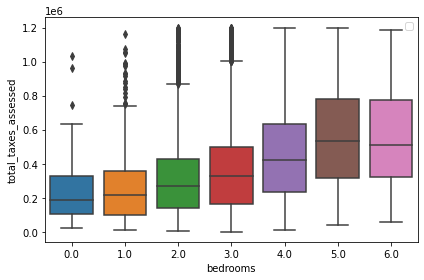

No handles with labels found to put in legend.


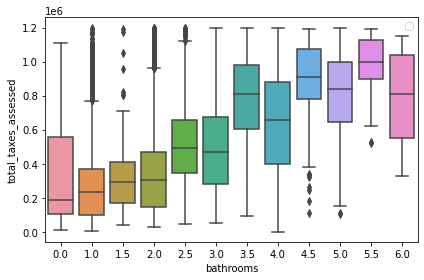

In [5]:
target = train.total_taxes_assessed
train_drop = train.drop(columns=["total_taxes_assessed","squarefeet","yearbuilt","county"])

# I use a for loop to boxplot my independent variables against our dependent one:
for col in train_drop:
    sns.boxplot(x=train_drop[col], y=target, data=train_drop)
    plt.ylabel('total_taxes_assessed')
    plt.xlabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

## Takeaways
### 1. Does the number of bedrooms and bathrooms in a house increase the cost of the home
#### it appears that the numberof bedrooms have a positive relationship with the cost of the price of house
#### additionally according to the charts the higher the number of bathrooms the higher the price

---

### 2. Is the price of the house influenced by the county/ location?


No handles with labels found to put in legend.


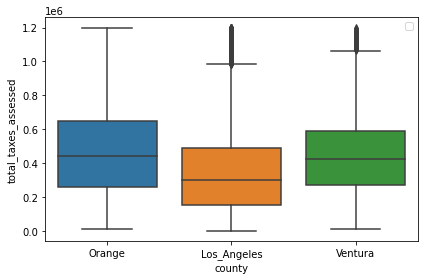

No handles with labels found to put in legend.


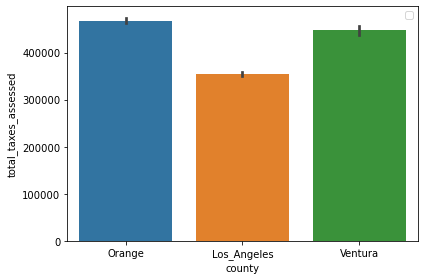

In [6]:
target = train.total_taxes_assessed
train_drop = train.drop(columns=["total_taxes_assessed","squarefeet","yearbuilt","bedrooms","bathrooms"])

# I use a for loop to boxplot my independent variables against our dependent one:
for col in train_drop:
    sns.boxplot(x=train_drop[col], y=target, data=train_drop)
    plt.ylabel('total_taxes_assessed')
    plt.xlabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

# I use a for loop to boxplot my independent variables against our dependent one:
for col in train_drop:
    sns.barplot(x=train_drop[col], y=target, data=train_drop)
    plt.ylabel('total_taxes_assessed')
    plt.xlabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Takeaways

### 2. Is the price of the house influenced by the county/ location?
#### It appears that houses are less expensive in LA and than in Ventura and Orange county respectively
#### However this does not seem like a strong relationship with the price, therefore this is a feature will be  explored after presenting my current findings



---

### 3. Does the age of the house matter when it comes to the price? 


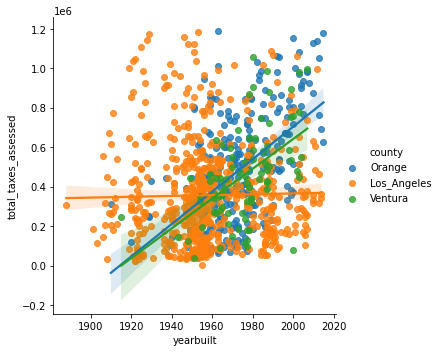

In [7]:
#this codetakes in a sample of the data and creates a scatter plot with hue that showes where houses
#in the sample are located and draws a regression line
sns.lmplot(x="yearbuilt", y="total_taxes_assessed", hue ="county", data=train.sample(1000))


## Takeaways
### 3. Does the age of the house matter when it comes to the price? 
#### The houses in Ventura and in Orange county appear to be more expensive the newer they are, unlike in Los angeles
#### this warrants a deeper investigetion when time permits

---

### 4. Does the size of the house in sqfeet influence the price?


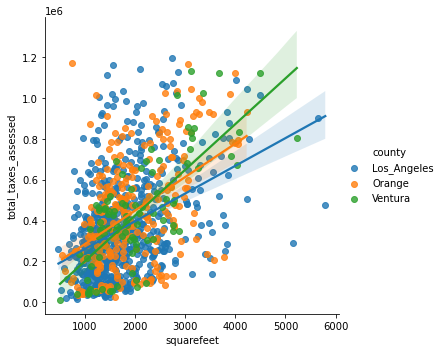

In [8]:
#here is a comparisson between squarefeet and total_taxes_assessed with the colors indicating what county the houses are in(picked a sample of 1000) 

sns.lmplot(x="squarefeet", y="total_taxes_assessed", hue ="county", data=train.sample(1000))


## Takeaways
### 4. Does the size of the house matter when it comes to the price? 
#### it appears that the size of the house has a high positive relationship with the price. this is also evident with the positive relationship between the number of bedrooms and total_taxes_assessed
#### ths feature will be used in the modeling process



---

## Summary 

### 1. Does the number of bedrooms and bathrooms in a house increase the cost of the home
- It appears that the number of bedrooms have a positive relationship with the cost of the price of house
- Additionally according to the charts the higher the number of bathrooms the higher the price

### 2. Is the price of the house influenced by the county/ location?
- It appears that houses are less expensive in LA and than in Ventura and Orange county respectively
- However this does not seem like a strong relationship with the price, therefore this feature will not be  explored in this report. I will revisit after

### 3. Does the age of the house matter when it comes to the price? 
- The houses in Ventura and in Orange county appear to be more expensive the newer they are, unlike in Los angeles

### 4. Does the size of the house matter when it comes to the price? 
- It appears that the size of the house has a high positive relationship with the price. This is also evident with the positive relationship between the number of bedrooms and total_taxes
- this feature will be used in the modeling process


#### In summary I will explore statistical relationships in bathrooms, bedrooms, the year built and square feet(size)


---

## Statistical tests

In [9]:
a = 0.05

### Hypothesis Testing
- In this section i will be checking the correlation between the variables that visually showed a relationship with the total_tax column
- Afterwards, I will proceed to pick 3 of the best variables to model with

#### $ H0 $ : the number of bathrooms have no relationship to the property prices

#### $ H1 $ : the higher the number of bathrooms, the higher the price of the house 

In [10]:
# here I will use Pearsons r to check the correlation between the variables 
x = train.bathrooms
y = train.total_taxes_assessed

corr, p = stats.pearsonr(x, y)
print(f'corr = {corr:.5f}')
print(f'p = {p:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I reject the null hypothesis")


corr = 0.43426
p = 0.00000
I reject the null hypothesis


---

#### $ H0 $ : the number of bedrooms have no relationship to the property prices
#### $ H1 $ : the higher the number of bedrooms, the higher the price of the house 

In [11]:
# this code takes in the number of bedrooms and the total taxes 
#returns correlation and p values to determine the statistical significance
x1 = train.bedrooms
y1 = train.total_taxes_assessed

corr1, p1 = stats.pearsonr(x1, y1)
print(f'corr = {corr1:.5f}')
print(f'p = {p1:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I reject the null hypothesis")


corr = 0.24929
p = 0.00000
I reject the null hypothesis


---

#### $H0$: the age of the house has no relationship to the property prices

#### $H1$:the newer the property the more expensive it is 

In [12]:
# this code takes in the year the property was built and the total taxes 
#returns r and p values to determine the statistical significance
x3= train["yearbuilt"]
y3 = train["total_taxes_assessed"]
r, p2 = stats.pearsonr(x3, y3)
print(f'r = {r:.5f}')
print(f'p = {p2:.5f}')
# however it is a weak correlation 
if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I reject the null hypothesis")

r = 0.26518
p = 0.00000
I reject the null hypothesis


---

#### $H0$: the size of the house in squarefeet does not have a relationship with the price

#### $H1$: the size of the house in squarefeet has a relatively strong correlation with the property prices

In [13]:
# this code takes in the squarefeet and the total taxes 
#returns r and p values to determine the statistical significance

x4= train["squarefeet"]
y4 = train["total_taxes_assessed"]
r1, p3 = stats.pearsonr(x4, y4)
print(f'r = {r1:.5f}')
print(f'p = {p3:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I reject the null hypothesis")

r = 0.50148
p = 0.00000
I reject the null hypothesis


---

### Correlation Matrix

In [14]:
#this code illustrates the correlation matrix where correlations are observed among different variables 
cor = train.corr()
cor

,bedrooms,bathrooms,squarefeet,total_taxes_assessed,yearbuilt
bedrooms,1.000000,0.619454,0.631366,0.249288,0.389015
bathrooms,0.619454,1.000000,0.808249,0.434259,0.557527
squarefeet,0.631366,0.808249,1.000000,0.501476,0.489558
total_taxes_assessed,0.249288,0.434259,0.501476,1.000000,0.265175
yearbuilt,0.389015,0.557527,0.489558,0.265175,1.000000


<AxesSubplot:>

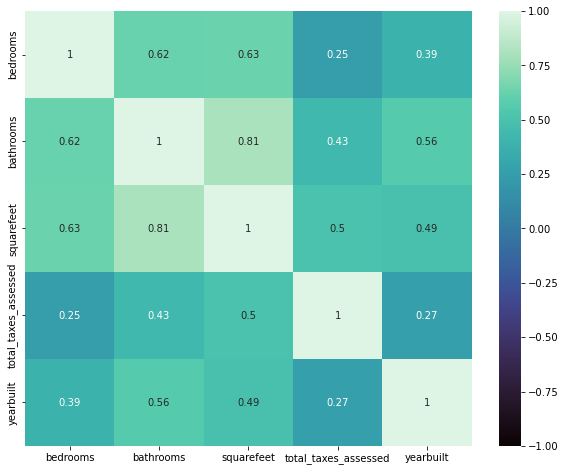

In [15]:
#here is a plot of the correlation coefficients 
plt.figure(figsize=(10,8))
sns.heatmap(cor,annot = True,cmap = 'mako',center = 0,vmin = -1, vmax = 1)

### Summary
- all of the variables had a positive correlation with the target variable
- however I will proceed to model with the three highest correlated variables
- these are:
    - bedrooms
    - bathrooms 
    - squarefeet
    

---

# Scaling

In [16]:
# This function takes in a data set that is split , makes a copy and uses the min max scaler 
# to scale all three data sets. additionally it adds the columns names on the scaled data and 
# returns trainedscaled data, validate scaled data and test scale

columns_to_scale = ["bedrooms","bathrooms","squarefeet"]
train_scaled, validate_scaled,test_scaled =prepare.scaling_zillow(train, validate, test, columns_to_scale)
train_scaled.head()

,bedrooms,bathrooms,squarefeet,total_taxes_assessed,yearbuilt,county
15738,0.500000,0.333333,0.293216,67857.0,1954.0,Orange
32066,0.500000,0.166667,0.160124,295125.0,1953.0,Los_Angeles
23254,0.666667,0.500000,0.540978,717274.0,2000.0,Orange
22616,0.500000,0.250000,0.219353,318217.0,1968.0,Orange
50357,0.666667,0.500000,0.423554,396546.0,1966.0,Los_Angeles


---

## BASELINE
Producing a baseline using mean and median in order to compare it with the RMSE 

In [17]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 

X_train, y_train = train_scaled, train_scaled["total_taxes_assessed"]
X_validate, y_validate = validate_scaled, validate_scaled.total_taxes_assessed
X_test, y_test = test_scaled, test_scaled.total_taxes_assessed
y_train = pd.DataFrame(train.total_taxes_assessed)
y_validate = pd.DataFrame(validate.total_taxes_assessed)
y_test = pd.DataFrame(test.total_taxes_assessed)


# 1. Predict housing pices 
y_train_mean = y_train['total_taxes_assessed'].mean()
y_train['y_train_mean'] = y_train_mean
y_validate['y_train_mean'] = y_train_mean

# 2. compute prices prediction
y_train_median = y_train['total_taxes_assessed'].median()
y_train['y_train_median'] = y_train_median
y_validate['y_train_median'] = y_train_median

# 3. RMSE for mean
rmse_train = mean_squared_error(y_train.total_taxes_assessed, y_train.y_train_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.total_taxes_assessed, y_validate.y_train_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
            "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE for median
rmse_train = mean_squared_error(y_train.total_taxes_assessed, y_train.y_train_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.total_taxes_assessed, y_validate.y_train_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
                  "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  264487.8 
Validate/Out-of-Sample:  264650.06
RMSE using Median
Train/In-Sample:  268181.81 
Validate/Out-of-Sample:  268086.55


---

### Bellow are 3 of my best models
- the Tweedie model was the least impressive but still approximately 30000 better than the baseline
- the Lasso lars and the linear regression models did much better at 40000 better than the baseline (15%)
- surprissingly both linear regression and lasso lars were almost identical...

## TweedieRegressor Model

In [18]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)
X_train_tr = X_train[["bedrooms","bathrooms","squarefeet"]]
X_validate_tr = X_validate[["bedrooms","bathrooms","squarefeet"]]

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_tr, y_train.total_taxes_assessed)

# predict train
y_train['total_taxes_pred'] = glm.predict(X_train_tr)

# evaluate: rmse
rmse_train_tr = mean_squared_error(y_train.total_taxes_assessed, y_train.total_taxes_pred)**(1/2)

# predict validate
y_validate['total_taxes_pred'] = glm.predict(X_validate_tr)

# evaluate: rmse
rmse_validate_tr = mean_squared_error(y_validate.total_taxes_assessed, y_validate.total_taxes_pred)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train_tr, 
      "\nValidation/Out-of-Sample: ", rmse_validate_tr)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  230302.39722767126 
Validation/Out-of-Sample:  227477.66019504415


---

## Lasso Lars Model

In [19]:
# create the model object
lars = LassoLars(alpha=1.0)
X_train_lars= X_train[["bedrooms","bathrooms","squarefeet"]]
X_validate_lars = X_validate[["bedrooms","bathrooms","squarefeet"]]
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_lars, y_train.total_taxes_assessed)

# predict train
y_train['total_taxes_pred1'] = lars.predict(X_train_lars)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.total_taxes_assessed, y_train.total_taxes_pred)**(1/2)

# predict validate
y_validate['total_taxes_pred1'] = lars.predict(X_validate_lars)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.total_taxes_assessed, y_validate.total_taxes_pred)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)

RMSE for Lasso + Lars
Training/In-Sample:  230302.39722767126 
Validation/Out-of-Sample:  227477.66019504415


---

## MODELING (features: bedrooms, bathrooms, squarefeet)
#### Best model is a linear regression with 3 features

In [21]:
# create the model object
lm = LinearRegression(normalize=True)
X_train = X_train[["bedrooms","bathrooms","squarefeet"]]
X_validate = X_validate[["bedrooms","bathrooms","squarefeet"]]
X_test = X_test[["bedrooms","bathrooms","squarefeet"]]
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.total_taxes_assessed)

# predict train
y_train['total_taxes_pred2'] = lm.predict(X_train)

# evaluate: rmse
rmse_train_lr = mean_squared_error(y_train.total_taxes_assessed, y_train.total_taxes_pred2)**(1/2)

# predict validate
y_validate['total_taxes_pred2'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate_lr = mean_squared_error(y_validate.total_taxes_assessed, y_validate.total_taxes_pred2)**(1/2)

# testing on the best model
y_test['total_taxes_pred2'] = lm.predict(X_test)

# evaluate: rmse
rmse_test_lr = mean_squared_error(y_test.total_taxes_assessed, y_test.total_taxes_pred2)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_lr, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lr, "RMSE for OLS using LinearRegression\ntest/In-Sample: ",rmse_test_lr)

RMSE for OLS using LinearRegression
Training/In-Sample:  226874.71769377927 
Validation/Out-of-Sample:  224745.86491873223 RMSE for OLS using LinearRegression
test/In-Sample:  224826.8407443043


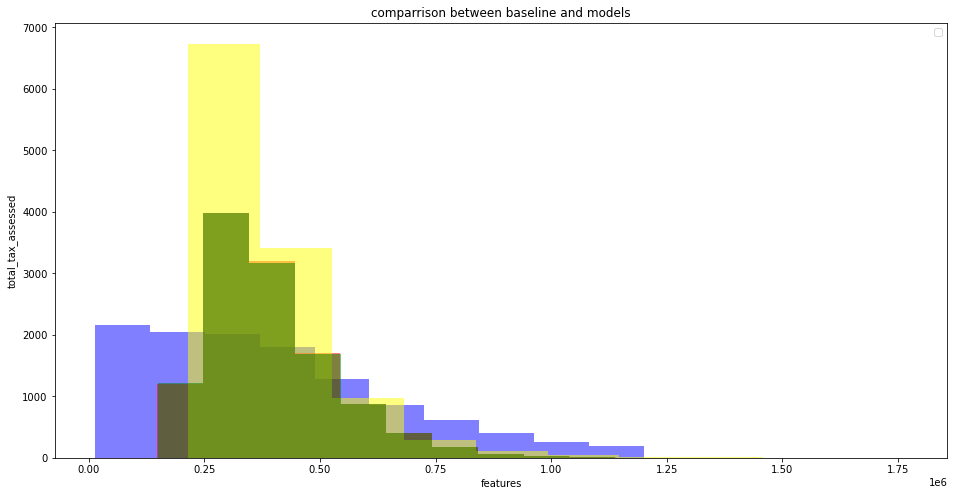

In [22]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.total_taxes_assessed, color='blue', alpha=.5, label="Actual values currently")
plt.hist(y_validate['total_taxes_pred2'], color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate['total_taxes_pred'], color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate['total_taxes_pred1'], color='green', alpha=.5, label="Lasso Lars")
plt.xlabel("features")
plt.ylabel("total_tax_assessed")
plt.title("comparrison between baseline and models") 
plt.legend("")
plt.show()

---

### Takeaways
- the linear regression shows the most promise with these three features.
- however there are concerns that these features are very similar or the bedrooms and the bathrooms are contained in the sqfeet calculations
- so far this Linear regression is the best model
- surprisingly, the Lasso Lars model results are almost identical to the linear regression model

### Baseline

RMSE using Mean

Train/In-Sample:  264487.8

Validate/Out-of-Sample:  264650.06

RMSE using Median

Train/In-Sample:  268181.81

Validate/Out-of-Sample:  268086.55

### Linear regression

RMSE for OLS using LinearRegression

Training/In-Sample:  226874.71769377927 

Validation/Out-of-Sample:  224745.86491873223





In [ ]:
RMSE_baseline_train = rmse_train 
RMSE_baseline_validate = rmse_validate
RMSE_train_lr = rmse_train_lr
RMSE_validate_lr = rmse_validate_lr
RMSE_test_lr = rmse_test_lr
Test_difference  = RMSE_baseline_train - RMSE_test_lr
print (f"Difference with Baseline Train = {RMSE_baseline_train-RMSE_train_lr}")
print(f"Difference with Baseline Validate = {RMSE_baseline_validate-RMSE_validate_lr}")
print(f"Difference with Baseline vs Test = {RMSE_baseline_train-RMSE_test_lr}")


---

### Conclusion

- #### In conclusion, despite the model being 220k from the regression line, the model was able to beat the baseline by atleast 40k.

- #### I found that squarefeet is one of the most important features to predict prices

- #### In order to make a better model, we should work on feature engineering maybe combining the squrefeet , bedrooms and bathrooms  

- #### In the future, we can include some feature engineering where we would combine sqfeet, bedrooms and bathrooms to make one feature.

- #### Additionally, with more time we can run other regression models to make the process more accurate

- #### There are more data values needed to further assess home values

            - interest rates in the market
            - housing demand from previous years (to determine the the trajectory of the trend)
            - zoning data and school zoning data should also be included in the data if possible(reduce nulls)